In [25]:
import torch
from torch import nn
from torchvision import datasets,transforms,models
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from pathlib import Path
from helper_functions import download_data
from engine import train
from data_setup import create_dataloaders
from utils import save_model
import pandas as pd
from timeit import default_timer as timer
import random

from PIL import Image

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [27]:
effnetb2_weights = models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms
effnetb2 = models.efficientnet_b2(effnetb2_weights)
manual_transform = transforms.Compose(
    [
        transforms.Resize((224,224),interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ]
)

In [28]:
effnetb2_transforms

functools.partial(<class 'torchvision.transforms._presets.ImageClassification'>, crop_size=288, resize_size=288, interpolation=<InterpolationMode.BICUBIC: 'bicubic'>)

In [ ]:
train_data = datasets.FashionMNIST(root=Path("data"),
                              train=True,
                              download=True,
                              transform=manual_transform,
                              target_transform=None)
test_data = datasets.FashionMNIST(root=Path("data"),
                             download=True,
                             train=False,
                             transform=manual_transform)

train_data,test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bicubic, max_size=None, antialias=True)
                Grayscale(num_output_channels=3)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bicubic, max_size=None, antialias=True)
                Grayscale(num_output_channels=3)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

In [30]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [31]:
for param in effnetb2.parameters():
    param.requires_grad = False
    
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(in_features=1408,out_features=len(class_names))
)

effnetb2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [32]:
train_dataloader= DataLoader(
    train_data,
    batch_size=256,
    shuffle=True,
    
)

test_dataloader= DataLoader(
    test_data,
    batch_size=256
)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x791b714caf80>,
 <torch.utils.data.dataloader.DataLoader at 0x791b714cb7f0>)

In [33]:
optimizer = torch.optim.Adam(
    params=effnetb2.parameters(),
    lr = 1e-3
)
loss_fn = nn.CrossEntropyLoss()

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [35]:
testi,testl = next(iter(test_data))

testi.shape
# plt.imshow(testi.permute(1,2,0))

torch.Size([3, 224, 224])

In [ ]:
effnetb2_results = train(
    effnetb2,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    epochs=10,
    device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8287 | train_acc: 75.5314 | test_loss: 0.5350 | test_acc: 82.3926
Epoch: 2 | train_loss: 0.5576 | train_acc: 81.1021 | test_loss: 0.4772 | test_acc: 83.5547
Epoch: 3 | train_loss: 0.5193 | train_acc: 81.9919 | test_loss: 0.4552 | test_acc: 84.0332
Epoch: 4 | train_loss: 0.5027 | train_acc: 82.3903 | test_loss: 0.4419 | test_acc: 84.5703
Epoch: 5 | train_loss: 0.4952 | train_acc: 82.5161 | test_loss: 0.4357 | test_acc: 84.6582
Epoch: 6 | train_loss: 0.4911 | train_acc: 82.4496 | test_loss: 0.4280 | test_acc: 84.8633
Epoch: 7 | train_loss: 0.4811 | train_acc: 83.0424 | test_loss: 0.4218 | test_acc: 85.0684
Epoch: 8 | train_loss: 0.4813 | train_acc: 82.9893 | test_loss: 0.4204 | test_acc: 85.2051
Epoch: 9 | train_loss: 0.4743 | train_acc: 82.9117 | test_loss: 0.4213 | test_acc: 85.0000
Epoch: 10 | train_loss: 0.4724 | train_acc: 83.0735 | test_loss: 0.4180 | test_acc: 85.4492


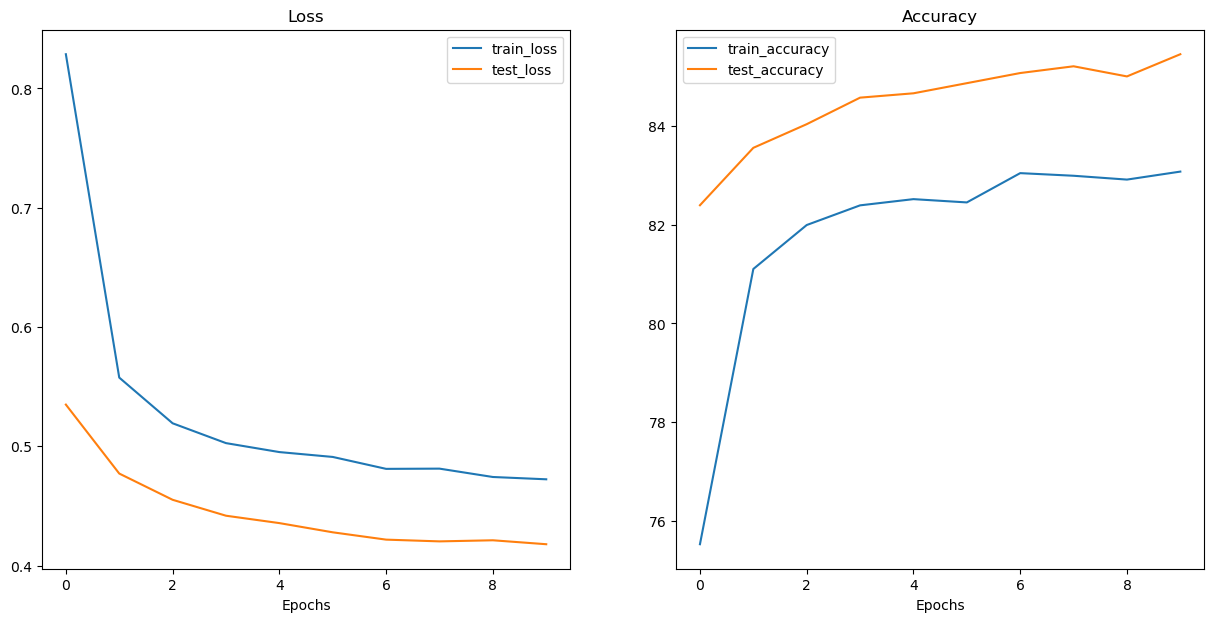

In [38]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [39]:
save_model(model=effnetb2,
           target_dir="models/",
           model_name="effnetb2_Fashion-MNIST.pt")

[INFO] Saving model to: models/effnetb2_Fashion-MNIST.pt


In [ ]:
compiled_model = torch.compile(effnetb2)

effnetb2_results = train(
    effnetb2,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    epochs=10,
    device=device)